# Brick Benchmark Model Compression

**Romain Beucher** romain.beucher (at) anu.edu.au

In [1]:
from underworld import UWGeodynamics as GEO
import numpy as np
from underworld import visualisation as vis

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
velocity = 2e-11 * u.meter / u.second
model_height = 10. * u.kilometer
bodyforce = 2700 * u.kilogram / u.metre**3 * 10. * u.meter / u.second**2

KL = model_height
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

# Model Geometry

In [4]:
Model = GEO.Model(elementRes=(128, 32),
                  minCoord=(-20. * u.kilometer, 0. * u.kilometer), 
                  maxCoord=(20. * u.kilometer, 10. * u.kilometer), 
                  gravity=(0.0, -10. * u.meter / u.second**2))

In [5]:
Model.minViscosity = 1e19 * u.pascal * u.second
Model.maxViscosity = 1e26 * u.pascal * u.second

# Add some Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
The *geodynamics* module is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

In [6]:
background = Model.add_material(name="Background", shape=GEO.shapes.Layer(top=Model.top, bottom=Model.bottom))
seed = Model.add_material(name="Background", shape=GEO.shapes.Box(minX=-400. * u.meters, maxX=400. * u.meter, bottom=Model.bottom, top=400. * u.meter))


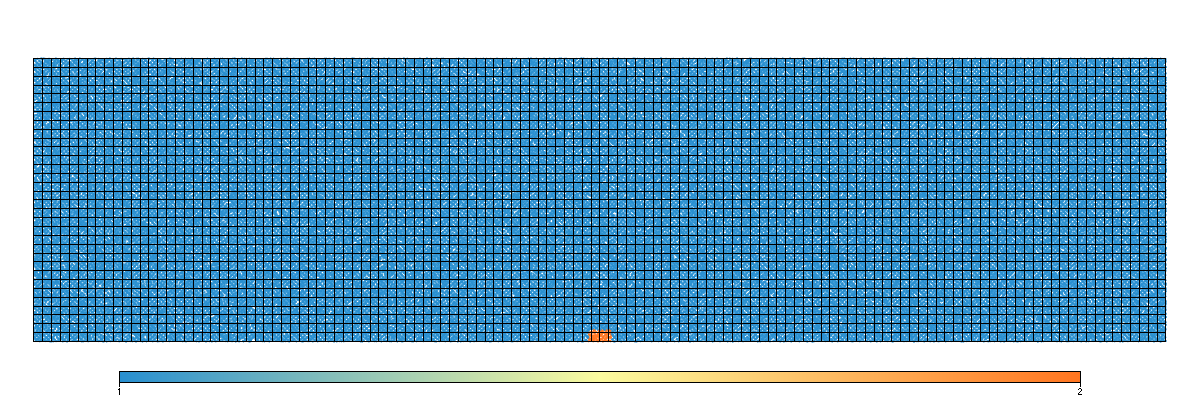

In [7]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField, fn_size=3.0)
Fig.Mesh(Model.mesh)
Fig.show()

## Material properties

In [8]:
background.density = 2700. * u.kilogram / u.metre**3
seed.density = 2700. * u.kilogram / u.metre**3

# Define Viscosities

Viscosities can be defined as a Quantity or a simple scalar value. It is also possible to load predefined rheologies from the rheology_library. 

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [9]:
background.viscosity = 1e25 * u.pascal * u.second
seed.viscosity = 1e20 * u.pascal * u.second

# Define Plasticity

Plastic behavior is assigned using the same approach as for viscosities.

In [10]:
friction_angle = 10

background.plasticity = GEO.DruckerPrager(cohesion=40. * u.megapascal,
                               frictionCoefficient=np.arctan(np.radians(friction_angle)))

# Boundary conditions


In [11]:
Model.set_velocityBCs(left=[2e-11 * u.meter / u.second, None],
                      right=[-2e-11 * u.meter / u.second, None],
                      bottom=[None, 0.0])

## Initialise Model

The model is initialize using the *init_model* method which will solve the initial steady state temperature field and the pressure field.

In [12]:
Model.init_model(pressure="lithostatic")


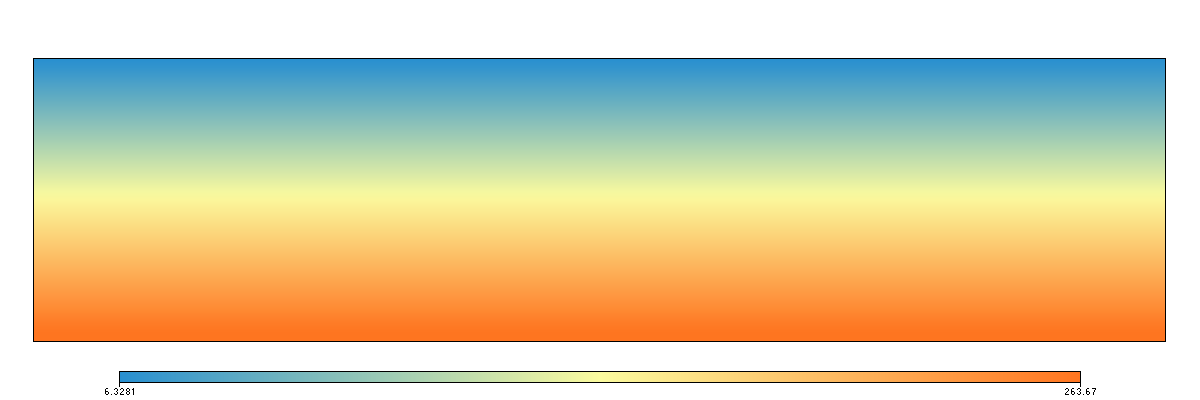

In [13]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, GEO.Dimensionalize(Model.pressureField, u.megapascal))
Fig.show()


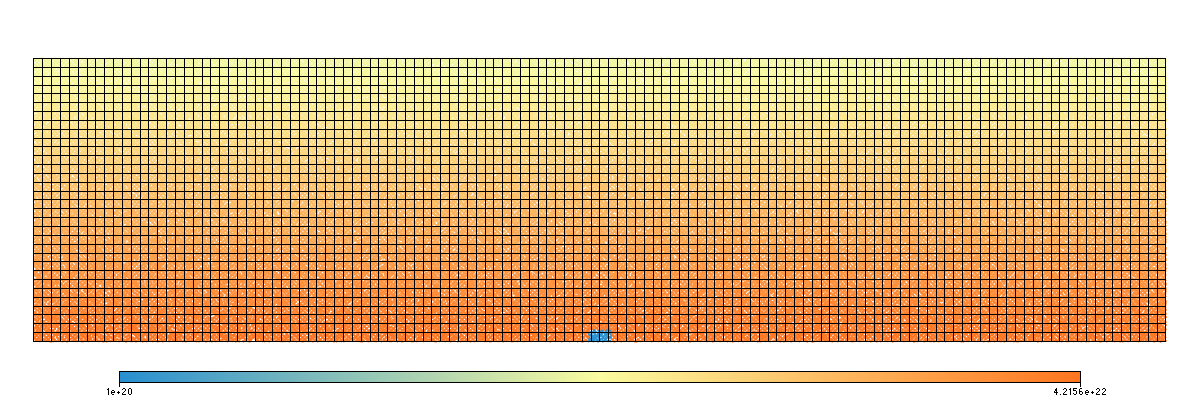

In [14]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, GEO.Dimensionalize(Model.viscosityField, u.pascal * u.second), fn_size=3.0)
Fig.Mesh(Model.mesh)
Fig.show()

In [15]:
Model.defaultStrainRate = 0.
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.min.iterations"] = 2
GEO.rcParams["initial.nonlinear.max.iterations"] = 20
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-7

In [16]:
!rm -rf outputs/
Model.run_for(nstep=1)

Running with UWGeodynamics version 0.9.4-dev-1011449(development)
Step:1 Model Time:  229401.16770090445 year dt: 229401.16770090448 year (2018-11-12 23:35:16)


1


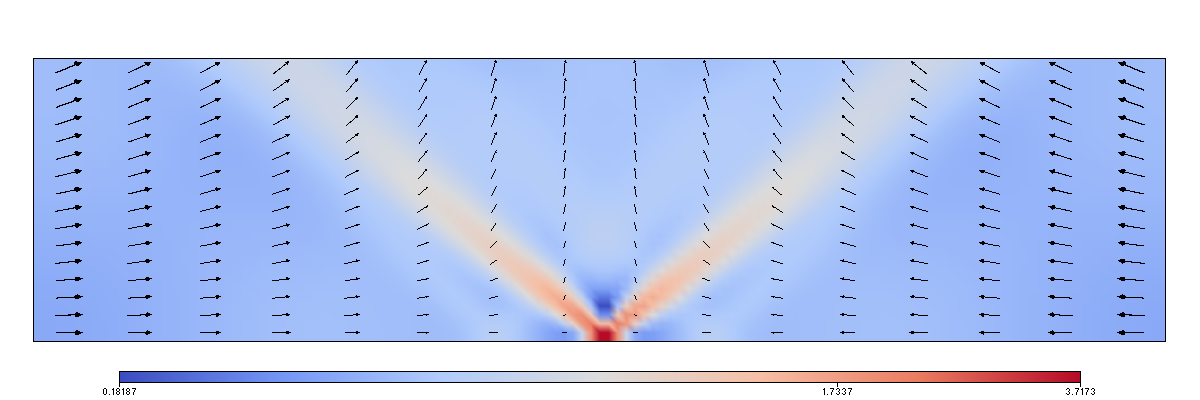

In [17]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.strainRateField, logScale=True, colours="coolwarm")
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()

In [18]:
Model.checkpoint(checkpointID=1)